In [50]:
'''Fitting code: EML binned fit implementing B&Z (arxiv:1309.1287)

__author__: Blaise Delaney
__email__ : blaise.delaney@cern.ch
'''

from common.header import *
from termcolor2 import c
import pprint 
plt.style.use(hep.style.ROOT)
plt.rcParams.update({
     "text.usetex": True,
#     "font.family": "serif",
#     "text.latex.preamble":r"\usepackage{amsmath}",
     })

# binning
with open("/usera/delaney/private/Bc2D0MuNuX/pyhf_Fit/config/config.json") as config_file:
    fit_config = json.load(config_file)
print(c(f"\nLoaded fit configuration").bold)
print(fit_config)

def integrate_pdf(tensor, to_project, fitvars_dict=fit_config):
    """for a given data/pdf integrate over one dimension to give the 1D projection along axis"""
    dims = np.array(range(len(FITVARS)))
    
    if len(FITVARS) == 2: 
        projection = np.sum(tensor.reshape(fitvars_dict[ FITVARS[0] ]["nbins"], -1), axis=tuple(np.delete(dims, to_project)) ) # checked formatting
    if len(FITVARS) == 3: 
        projection = np.sum(tensor.reshape(fitvars_dict[ FITVARS[0] ]["nbins"], fitvars_dict[ FITVARS[1] ]["nbins"], fitvars_dict[ FITVARS[-1] ]["nbins"]), axis=tuple(np.delete(dims, to_project)) ) # checked formatting
    return projection 

# bounds
MCORR_LOW = fit_config["B_plus_MCORR"]["range"][0]
MCORR_HIGH = fit_config["B_plus_MCORR"]["range"][-1]
LTIME_LOW=0.0005
LTIME_HIGH=0.005
LTIME_NBINS=fit_config["B_plus_FIT_LTIME"]["nbins"]
MCORR_NBINS=fit_config["B_plus_MCORR"]["nbins"]


Loaded fit configuration
{'B_plus_MCORR': {'is_var_axis': 'False', 'nbins': 30, 'range': [4200, 7200]}, 'B_plus_FIT_LTIME': {'is_var_axis': 'False', 'nbins': 1, 'range': [0.0, 0.004]}}


In [63]:
misid_df = pandas.read_pickle(f"/usera/delaney/private/Bc2D0MuNuX/pyhf_Fit/DATA_TEMPLATES/D0MuNu/2018/MisID.pkl")
comb_df  = pandas.read_pickle(f"/usera/delaney/private/Bc2D0MuNuX/pyhf_Fit/DATA_TEMPLATES/D0MuNu/2018/EvtMix.pkl")
dcs_df   = pandas.read_pickle(f"/usera/delaney/private/Bc2D0MuNuX/pyhf_Fit/DATA_TEMPLATES/D0MuNu/2018/DCS.pkl")
cf_df    = pandas.read_pickle(f"/usera/delaney/private/Bc2D0MuNuX/pyhf_Fit/DATA_TEMPLATES/D0MuNu/2018/CF.pkl")

In [64]:
# derive a yeild constraint on misID
MISID_CONSTRAINT = ufloat( np.sum(misid_df["misid_w"]*misid_df["sw"]), np.sqrt(np.sum( (misid_df["misid_w"]*misid_df["sw"])**2  )) ) 
print(c(f"MisID constraint: {MISID_CONSTRAINT}").magenta)

# a big ugly, from porting from dev.ipynb
fitvars= list(fit_config.keys())
FITVARS = list(fit_config.keys())
N_FITVARS = len(FITVARS)
TOT_BINS = 1
for i in range(N_FITVARS):
    TOT_BINS*=(fit_config[FITVARS[i]]["nbins"])

print(c(f"TOT nBins = {TOT_BINS}").yellow)

MisID constraint: (1.671+/-0.016)e+04
TOT nBins = 30


In [65]:
# track components (might want to remove this in tidier version of code)
rfiles = {}
rfiles["DCS"] = dcs_df
rfiles["CF"] = cf_df
rfiles["MISID"] = misid_df
rfiles["COMB"] = comb_df

In [66]:
import boost_histogram as BH
def load_bh(idx):
    print(c(f"\nFilling mode: {idx}").cyan)
    indf = rfiles[idx]
    
    if len(FITVARS) == 2: 
        samples = [np.array(indf[fitvars[0]]), np.array(indf[fitvars[1]])]
    
    if idx=="MISID":
        wts = indf["misid_w"]*indf[f"sw"] # if misID, weights = sw x fully-extracted misID weight (includes anti-prescale)
    if idx=="COMB":
        wts = indf["GBR_w"]*indf[f"sw"] # if COMB, weights = sw x GBR weight from evt mixing       
    if idx=="CF" or idx=="DCS":
        wts = indf[f"sw"] # in any other case, we only care about the sw from fit to D0 mass

    _nbins_1  = fit_config[fitvars[0]]["nbins"]
    _minvar_1 = fit_config[fitvars[0]]["range"][0] 
    _maxvar_1 = fit_config[fitvars[0]]["range"][-1] 

    _nbins_2  = fit_config[fitvars[1]]["nbins"]
    _minvar_2 = fit_config[fitvars[1]]["range"][0] 
    _maxvar_2 = fit_config[fitvars[1]]["range"][-1] 

    if fit_config[fitvars[0]]["is_var_axis"]=="False":
        ax_1 = BH.axis.Regular(_nbins_1, _minvar_1, _maxvar_1)
    if fit_config[fitvars[0]]["is_var_axis"]=="True":
        ax_1 = BH.axis.Variable(fit_config[fitvars[0]]["range"])

    if fit_config[fitvars[1]]["is_var_axis"]=="False":
        ax_2 = BH.axis.Regular(_nbins_2, _minvar_2, _maxvar_2)
    if fit_config[fitvars[1]]["is_var_axis"]=="True":
        ax_2 = BH.axis.Variable(fit_config[fitvars[1]]["range"]) 
    
    if len(FITVARS)==2:
        if idx=="D0_MC16" or idx=="Dst_MC16":
            wbh = BH.Histogram( ax_1, ax_2 )
            wbh.fill( *samples )
        else:
            wbh = BH.Histogram( ax_1, ax_2, storage=BH.storage.Weight() )
            wbh.fill( *samples, weight=wts)
    
    print(c(f"Histogram summary: {wbh}").blue)
    return wbh

# load the boost objects encoding CF, DCS, MISID, COMB and MC templates
data_driven_samples = ("DCS", "CF", "MISID", "COMB")
MC_samples = ("D0_MC16", "Dst_MC16")
fit_components = ("CF", "COMB", "MISID", "D0_MC16", "Dst_MC16")

In [67]:
# load seperately-generated MC hists
MC_hists = {}
with open("/usera/delaney/private/Bc2D0MuNuX/pyhf_Fit/MC/pkl/D0MuNu/2016/D0_MC16.pkl", "rb") as f_dz: 
    MC_hists["D0_MC16"] = pickle.load(f_dz)
    print(c(f"\nFilling mode : D0_MC16").cyan)
    print(c(f"{MC_hists['D0_MC16']}").blue)
with open("/usera/delaney/private/Bc2D0MuNuX/pyhf_Fit/MC/pkl/D0MuNu/2016/Dst_MC16.pkl", "rb") as f_dst: 
    MC_hists["Dst_MC16"] = pickle.load(f_dst)
    print(c(f"\nFilling mode : Dst_MC16").cyan)
    print(c(f"{MC_hists['Dst_MC16']}").blue)


Filling mode : D0_MC16
Histogram(
  Regular(30, 4200, 7200),
  Regular(1, 0, 0.004),
  storage=Double()) # Sum: 22545.0 (22573.0 with flow)

Filling mode : Dst_MC16
Histogram(
  Regular(30, 4200, 7200),
  Regular(1, 0, 0.004),
  storage=Double()) # Sum: 21401.0 (21424.0 with flow)


In [68]:
# store cvals and err of templates and data
template_vals = {}
template_errs = {}

# # weighted data with dedicated storage
for comp in data_driven_samples: 
    bh = load_bh(comp)
    template_vals[f"{comp}"] = bh.view().value.flatten("F")
    template_errs[f"{comp}"] = (bh.view().variance**.5).flatten("F")
    
# MC has a regular storage
for sim in MC_samples:
    template_vals[f"{sim}"] = MC_hists[sim].view().flatten("F")
    template_errs[f"{sim}"] = np.sqrt( MC_hists[sim].view().flatten("F") ) # poisson error

# quick formatting checks 
for s in template_vals.values(): assert(len(s) == TOT_BINS)
for s in template_errs.values(): assert(len(s) == TOT_BINS)


Filling mode: DCS
Histogram summary: Histogram(
  Regular(30, 4200, 7200),
  Regular(1, 0, 0.004),
  storage=Weight()) # Sum: WeightedSum(value=62269.1, variance=108793) (WeightedSum(value=64745.7, variance=113027) with flow)

Filling mode: CF
Histogram summary: Histogram(
  Regular(30, 4200, 7200),
  Regular(1, 0, 0.004),
  storage=Weight()) # Sum: WeightedSum(value=9.19649e+06, variance=9.54804e+06) (WeightedSum(value=9.71389e+06, variance=1.00837e+07) with flow)

Filling mode: MISID
Histogram summary: Histogram(
  Regular(30, 4200, 7200),
  Regular(1, 0, 0.004),
  storage=Weight()) # Sum: WeightedSum(value=15946, variance=25938.7) (WeightedSum(value=16709.6, variance=27179.7) with flow)

Filling mode: COMB
Histogram summary: Histogram(
  Regular(30, 4200, 7200),
  Regular(1, 0, 0.004),
  storage=Weight()) # Sum: WeightedSum(value=162606, variance=668502) (WeightedSum(value=165201, variance=684520) with flow)


In [69]:
# # ===================================================
# #       PATCH: load the charm fit yield error
# # ---------------------------------------------------
# ax_1 = BH.axis.Regular(20, 4200, 7200, underflow=False, overflow=False )
# ax_2 = BH.axis.Regular(3, 0, 0.005, underflow=False, overflow=False )
# ch_wbh = BH.Histogram( ax_1, ax_2, storage=BH.storage.Weight() )

# samples = [np.array(dcs_df[fitvars[0]]), np.array(dcs_df[fitvars[1]])]
# ch_wbh.fill( *samples )
# # ===================================================

In [70]:
#======================================================
#                   BOHM & ZECH                       #
#======================================================
# check that the requirement for B&Z is met: DCS->sum(w), others->mu_i
assert(template_vals["DCS"].all()>0)

# prepare samples: derive scaling factor from observations
s_i = template_errs["DCS"]**2/template_vals["DCS"].flatten("F") # for weighted fits, sum(w**2) is err; correctness check: done
assert(s_i.all() == (load_bh("DCS").view().variance/load_bh("DCS").view().value).all())

# scaled observed data
obs = template_vals["DCS"]/s_i
print(c(f"Integral of scaled obs: {np.sum(obs)}").magenta)

# scale the rest accordingly
muprime_vals = {} # container for scaled fit components
muprime_errs = {} # contained for errors on scaled fit components

# normalise the scaled muprimes (=the scaled expectations)
for comp in fit_components:
    muprime_vals[f"{comp}"] = 1./np.sum( template_vals[f"{comp}"] ) * template_vals[f"{comp}"] / s_i  
    muprime_errs[f"{comp}"] = 1./np.sum( template_vals[f"{comp}"] ) * template_errs[f"{comp}"] / s_i 

# now proceed to extract scale factor and B+ constraint
norm_scale_factor = np.sum(obs)/np.sum(template_vals["DCS"]) # n->n'

# B+
# from PDG, get the BFs
CF = ufloat(3.950e-2, 0.031e-2)
DCS = ufloat(1.50e-4, 0.07e-4)

# scale factor for CF_y -> B+_y constraint in the fit 
R = DCS/CF
# compute the error as sqrt(sum(w**2))
CF_n = load_bh("CF").sum().value
print(c("Consistency check on B+ raw yield").green.underline)
print(c(f"{np.sum(load_bh('CF').view().value)}").green)
print(c(f"{CF_n}").green)
#assert(CF_n == np.sum(load_bh("CF").view().value))
CF_s = load_bh("CF").sum().variance**.5 
CF_y = ufloat( CF_n, CF_s )
bu_y_constraint = CF_y * R
s_i_scaled_bu_y_constraint = bu_y_constraint * norm_scale_factor 

print(c("B+ constraint checks").bold)
print(f"Ratio DCS/CF = {R}")
print(f"Un(s_i-)scaled B+ yield = {bu_y_constraint}")
print(f"s_i-scaled B+ yield = {s_i_scaled_bu_y_constraint}")

# need to take into account pdf not normed to 1; see notebooks for explanation
scaled_bu_y_constraint = s_i_scaled_bu_y_constraint / muprime_vals["CF"].sum()
print(f"s_i-scaled B+ yield accounting for normalisation = {scaled_bu_y_constraint}")

# read in the unscaled misid constraint
raw_misid_y_constr = MISID_CONSTRAINT
s_i_scaled_misid_y_constraint = raw_misid_y_constr*norm_scale_factor 
scaled_misid_y_constraint = s_i_scaled_misid_y_constraint / muprime_vals["MISID"].sum()
#scaled_misid_y_constraint = s_i_scaled_misid_y_constraint / muprime_vals["old_MISID"].sum()

print(c("MisID constraint checks").bold)
print(f"Norm scale factor = {norm_scale_factor}")
print(f"s_i-scaled misID yield = {s_i_scaled_misid_y_constraint}")
print(f"s_i-scaled misID yield norm = {scaled_misid_y_constraint}")

print(c(f"\nContraints on the B&Z-scaled B+ and MisID templates successfully derived").yellow)


Filling mode: DCS
Histogram summary: Histogram(
  Regular(30, 4200, 7200),
  Regular(1, 0, 0.004),
  storage=Weight()) # Sum: WeightedSum(value=62269.1, variance=108793) (WeightedSum(value=64745.7, variance=113027) with flow)

Filling mode: DCS
Histogram summary: Histogram(
  Regular(30, 4200, 7200),
  Regular(1, 0, 0.004),
  storage=Weight()) # Sum: WeightedSum(value=62269.1, variance=108793) (WeightedSum(value=64745.7, variance=113027) with flow)
Integral of scaled obs: 35940.10185164047

Filling mode: CF
Histogram summary: Histogram(
  Regular(30, 4200, 7200),
  Regular(1, 0, 0.004),
  storage=Weight()) # Sum: WeightedSum(value=9.19649e+06, variance=9.54804e+06) (WeightedSum(value=9.71389e+06, variance=1.00837e+07) with flow)
Consistency check on B+ raw yield

Filling mode: CF
Histogram summary: Histogram(
  Regular(30, 4200, 7200),
  Regular(1, 0, 0.004),
  storage=Weight()) # Sum: WeightedSum(value=9.19649e+06, variance=9.54804e+06) (WeightedSum(value=9.71389e+06, variance=1.0083

In [71]:
#======================================================
#                     pyhf spec                       #
#======================================================
print(c(f"\nPreparing the fit schema").yellow)
# CALCULATION BY MELIC ET AL, arXiv:1909.01213
BF_Bc2D0MuNu_3ptSR = ufloat(2.4e-5, 0.4e-5)
BF_Bc2DstMuNu_3ptSR = ufloat(7e-5, 3e-5)

# ====== 2016 efficiencies ====== 
eff_D0MuNu= ufloat(0.269, 0.001)
eff_D0gMuNu= ufloat(0.255, 0.002)
eff_D0pi0MuNu= ufloat(0.256, 0.001)

# take weighted averege for D* efficiencies
Dst_toD0g_BF = ufloat(0.353, 0.009)
Dst_toD0pi0_BF = ufloat(0.647, 0.009)

# compute weighted average 
eff_DstMuNu = (Dst_toD0g_BF*eff_D0gMuNu + Dst_toD0pi0_BF*eff_D0pi0MuNu)/(Dst_toD0g_BF+Dst_toD0pi0_BF)
print(c(f"\n==================================================").cyan)
print(c(f"Ratio of BF: D0/D* = {BF_Bc2D0MuNu_3ptSR/BF_Bc2DstMuNu_3ptSR}\n").cyan)
print(c(f"Extracted weighted average for Dst efficiency = {eff_DstMuNu}").cyan)
print(c(f"D0 efficiency = {eff_D0MuNu}").cyan)
print(c(f"Efficiency ratio : D0/D*= {eff_D0MuNu / eff_DstMuNu}").cyan)


# final kappa: N_D0/NDst = [BF(D0)*eff(D0)] / [BF(D*)*eff(D*)]
kappa = (BF_Bc2D0MuNu_3ptSR*eff_D0MuNu) / (BF_Bc2DstMuNu_3ptSR*eff_DstMuNu) # gaussian-constrained scaling: espress D0 as a function of Dst
print(c(f"\nKappa factor from 3ptSR, efficiency-corrected (2016) = {kappa:.4f}").blue)
print(c(f"==================================================\n").cyan)
# moving onto the spec: first formulate the standalone samples 

Dst_sample = {
                    "name": "signal_DstMuNu",
                    "data": ( muprime_vals["Dst_MC16"] ).tolist(),
                    "modifiers": [
                        # need to normalise to unity the signal templates to share the Dst normfactor
                        {"name": "dst_intgr", "type": "normfactor", "data": None},
                        {"name": "beeston_barlow", "type": "staterror", "data": muprime_errs["Dst_MC16"].tolist() }, # branch-speficific per-bin variation
                        {"name": "dst_sig_y", "type": "normfactor", "data": None }, # floating normalisation
                        ]
}

D0_sample = {
                    "name": "signal_D0MuNu",
                    "data": ( muprime_vals["D0_MC16"] ).tolist(),
                    "modifiers": [
                        # need to normalise to unity the signal templates to share the Dst normfactor
                        {"name": "dz_intgr", "type": "normfactor", "data": None},
                        {"name": "beeston_barlow", "type": "staterror", "data": muprime_errs["D0_MC16"].tolist() }, # branch-speficific per-bin variation
                        {"name": "dst_sig_y", "type": "normfactor", "data": None }, # floating normalisation
                        # INTRODUCE CONSTRAINT BY MELIC ET AL, arXiv:1909.01213
                        {"name": "kappa", "type": "normsys", "data": {"lo" : kappa.n-kappa.s, "hi": kappa.n+kappa.s} }, # gaussian constraint of prediction of ratios of signal BFs
                        ]
}

comb_sample = {
                    "name": "combinatorial",
                    "data": muprime_vals["COMB"].tolist(),
                    "modifiers": [
                        {"name": "beeston_barlow", "type": "staterror", "data": muprime_errs["COMB"].tolist() }, # branch-speficific per-bin variation
                        {"name": "comb_y", "type": "normfactor", "data": None }, # floating normalisation
                        ]
}

misid_sample = {  
                    "name": "misid",
                    #"data": muprime_vals["MISID"].tolist(),
                    "data": muprime_vals["MISID"].tolist(),
                    "modifiers": [
                        {"name": "beeston_barlow", "type": "staterror", "data": muprime_errs["MISID"].tolist() }, # branch-speficific per-bin variation
                        #{"name": "misid_y_constr", "type": "normsys", "data": {"lo" : scaled_misid_y_constraint.n - scaled_misid_y_constraint.s, "hi": scaled_misid_y_constraint.n + scaled_misid_y_constraint.s} }, # gaussian constraint
                        {"name": "misid_y_constr", "type": "normfactor", "data": None}, # gaussian constraint
                        ]
                    }

bu_sample = {  
                    "name": "bu",
                    "data": muprime_vals["CF"].tolist(),
                    "modifiers": [
                        {"name": "beeston_barlow", "type": "staterror", "data": muprime_errs["CF"].tolist() }, # branch-speficific per-bin variation
                        {"name": "bu_y_constr", "type": "normsys", "data": {"lo" : scaled_bu_y_constraint.n - scaled_bu_y_constraint.s, "hi": scaled_bu_y_constraint.n + scaled_bu_y_constraint.s} }, # gaussian constraint
                        #{"name": "bu_y_constr", "type": "normfactor", "data": None}, # gaussian constraint
                        ]
                    }

# compile standalone gaussain-constrained models
# B+
bu_template = pyhf.Model(
  {
    "channels": [
      {
        "name": "singlechannel",
        "samples": [
              {  
                  "name": "bu",
                  "data": muprime_vals["CF"].tolist(),
                  "modifiers": [
                      # remove BB from this standalone template, as not shared with anything else; fold in bin-wise variations later
                      #{"name": "bu_y_constr", "type": "normfactor", "data": None}, # gaussian constraint
                      {"name": "bu_y_constr", "type": "normsys", "data": {"lo" : scaled_bu_y_constraint.n - scaled_bu_y_constraint.s, "hi": scaled_bu_y_constraint.n + scaled_bu_y_constraint.s} }, # gaussian constraint
                  ]
              }          
          ]
      }
    ]
  }, poi_name=None
)

# misid
misid_template = pyhf.Model(
  {
    "channels": [
      {
        "name": "singlechannel",
        "samples": [
              {  
                  "name": "misid",
                  "data": muprime_vals["MISID"].tolist(),
                  #"data": muprime_vals["old_MISID"].tolist(),
                  "modifiers": [
                      # remove BB from this standalone template, as not shared with anything else; fold in bin-wise variations later
                      #{"name": "misid_y_constr", "type": "normsys", "data": {"lo" : scaled_misid_y_constraint.n - scaled_misid_y_constraint.s, "hi": scaled_misid_y_constraint.n + scaled_misid_y_constraint.s} }, # gaussian constraint
                      {"name": "misid_y_constr", "type": "normfactor", "data": None }, # gaussian constraint
                  ]
              }         
          ]
      }
    ]
  }, poi_name=None
)

Dst_template = pyhf.Model(
    {
        "channels": [
            {
                "name": "singlechannel",
                "samples": [
                    {
                    "name": "signal_DstMuNu",
                    "data": ( muprime_vals["Dst_MC16"] ).tolist(),
                    "modifiers": [
                        # need to normalise to unity the signal templates to share the Dst normfactor
                        {"name": "dst_intgr", "type": "normfactor", "data": None},
                        {"name": "dst_sig_y", "type": "normfactor", "data": None }, # floating normalisation
                    ]
                    }
                ]
            }
        ]
    },poi_name=None
)

D0_template = pyhf.Model(
    {
        "channels": [
            {
                "name": "singlechannel",
                "samples":[
                    {
                    "name": "signal_D0MuNu",
                    "data": ( muprime_vals["D0_MC16"] ).tolist(),
                    "modifiers": [
                        # need to normalise to unity the signal templates to share the Dst normfactor
                        {"name": "dz_intgr", "type": "normfactor", "data": None},
                        {"name": "dst_sig_y", "type": "normfactor", "data": None }, # floating normalisation
                        # INTRODUCE CONSTRAINT BY MELIC ET AL, arXiv:1909.01213
                        {"name": "kappa", "type": "normsys", "data": {"lo" : kappa.n-kappa.s, "hi": kappa.n+kappa.s} }, # gaussian constraint of prediction of ratios of signal BFs
                        ]
                    }
                ]
            }
        ]
    },poi_name=None
)



spec = {
    "channels": [
        {
            "name": "singlechannel",
            "samples": [
                D0_sample,
                Dst_sample,
                comb_sample,
                bu_sample, 
                misid_sample
            ]
        },
    ],
    "observations": [
        {
            "name": "singlechannel",
            "data": obs.tolist(),
        },
    ],
    "measurements": [
        { 
            "name": "sig_y_extraction",
            "config": {
                "poi": "dst_sig_y",
                "parameters": [
                    # bounds on floatig normalisations 
                    {"name":"dst_sig_y", "bounds": [[ 1e-6, obs.sum() ]], "inits":[1e3]},
                    #{"name":"dz_sig_y", "bounds":[[ 100, obs.sum() ]], "inits":[1e3]},
                    {"name":"comb_y", "bounds":   [[ 1e-6, obs.sum() ]], "inits":[1e3]},
                    {"name":"dst_intgr", "inits": [1./np.sum(muprime_vals["Dst_MC16"])], "fixed":True}, # fix template normaliation
                    {"name":"dz_intgr", "inits": [1./np.sum(muprime_vals["D0_MC16"])], "fixed":True}, # fix template normalisation
                    {"name":"misid_y_constr", "bounds":   [[ 1e-6, obs.sum() ]], "inits":[1e4]},
                    # {"name":"bu_y_constr", "bounds":   [[ 0, obs.sum() ]], "inits":[2e4]},
                ]
            }
        }
    ],
    "version": "1.0.0"
}

# some long-winded hackly way to produce a json file preserving the format and check the schema
spec = str(json.dumps(spec, indent=4)).replace("None", "null").replace("True", "true")
SCHEMA = "/usera/delaney/private/Bc2D0MuNuX/pyhf_Fit/config/model_spec.json"
if os.path.exists(SCHEMA) : os.remove(SCHEMA) # remove previous fit schema
with open(SCHEMA,'w') as outfile:
    outfile.write(spec)

# validate schema
workspace = json.load(open(SCHEMA))
schema = requests.get('https://scikit-hep.org/pyhf/schemas/1.0.0/workspace.json').json()
# If no exception is raised by validate(), the instance is valid.
jsonschema.validate(instance=workspace, schema=schema)
print(c("SUCCESS: validation of workspace complete").green)
workspace = pyhf.Workspace(workspace)
print(c("SUCCESS: workspace read in").green)


Preparing the fit schema

Ratio of BF: D0/D* = 0.34+/-0.16

Extracted weighted average for Dst efficiency = 0.2556+/-0.0010
D0 efficiency = 0.2690+/-0.0010
Efficiency ratio : D0/D*= 1.052+/-0.006

Kappa factor from 3ptSR, efficiency-corrected (2016) = 0.3608+/-0.1659

SUCCESS: validation of workspace complete
SUCCESS: workspace read in


In [72]:
#======================================================
#                     Run the fit                     #
#======================================================
pdf = workspace.model(measurement_name = "sig_y_extraction")
print(f"   samples: {pdf.config.samples}")
print(f" modifiers: {pdf.config.modifiers}")
print(f"parameters: {pdf.config.par_order}")
data = workspace.data(pdf)
fit_result, likelihood= pyhf.infer.mle.fit(data, pdf, return_fitted_val=True,return_uncertainties=True)

bestfit_pars, par_uncerts = fit_result.T

print(c("\nFit results:").bold)
par_name_dict = {k: v["slice"].start for k, v in pdf.config.par_map.items()}
PRESCALED_FIT_RESULTS = {}
for k, v in par_name_dict.items():
    PRESCALED_FIT_RESULTS[k] = ufloat(bestfit_pars[v], par_uncerts[v])
    print(f"Extracted value of {k} = {bestfit_pars[v]} +/- {par_uncerts[v]}")

# retrieve the parameter indices
bb = bestfit_pars[1:par_name_dict["dst_sig_y"]]

print(c("\nScaled constraints: B+").green.underline)
print(c("Central value of B+ constraint:").yellow, scaled_bu_y_constraint.n)
print(c("B+ constraint @ +1\u03C3:").yellow, scaled_bu_y_constraint.n + scaled_bu_y_constraint.s)
print(c("B+ constraint @ -1\u03C3:").yellow, scaled_bu_y_constraint.n - scaled_bu_y_constraint.s)
print(c("\nFit results: B+").green.underline)
print(c("Extracted fit parameter: ").red, PRESCALED_FIT_RESULTS["bu_y_constr"])
print(c("Fitted B+ yield w/o BB:").red.bold, np.sum(bu_template.expected_data( [ PRESCALED_FIT_RESULTS["bu_y_constr"].n], include_auxdata=False ))/muprime_vals["CF"].sum())
print(c("Fitted B+ yield x BB:").red.bold, np.sum(bu_template.expected_data( [ PRESCALED_FIT_RESULTS["bu_y_constr"].n], include_auxdata=False )*bb)/muprime_vals["CF"].sum())
print()
print(c("\nScaled constraints: MISID").green.underline)
print(c("Central value of misID constraint:").yellow, scaled_misid_y_constraint.n)
print(c("misID constraint @ +1\u03C3:").yellow, scaled_misid_y_constraint.n + scaled_misid_y_constraint.s)
print(c("misID constraint @ +1\u03C3:").yellow, scaled_misid_y_constraint.n - scaled_misid_y_constraint.s)
print(c("\nFit results: MISID").green.underline)
print(c("Extracted misID parameter of interest :").red, PRESCALED_FIT_RESULTS["misid_y_constr"].n)
print(c("Fitted MisID yield w/o BB:").red.bold, np.sum(misid_template.expected_data( [ PRESCALED_FIT_RESULTS["misid_y_constr"].n], include_auxdata=False ))/muprime_vals["MISID"].sum())
print(c("Fitted MisID yield x BB:").red.bold, np.sum(misid_template.expected_data( [ PRESCALED_FIT_RESULTS["misid_y_constr"].n], include_auxdata=False )*bb)/muprime_vals["MISID"].sum())

   samples: ['bu', 'combinatorial', 'misid', 'signal_D0MuNu', 'signal_DstMuNu']
 modifiers: [('beeston_barlow', 'staterror'), ('bu_y_constr', 'normsys'), ('comb_y', 'normfactor'), ('dst_intgr', 'normfactor'), ('dst_sig_y', 'normfactor'), ('dz_intgr', 'normfactor'), ('kappa', 'normsys'), ('misid_y_constr', 'normfactor')]
parameters: ['dz_intgr', 'beeston_barlow', 'dst_sig_y', 'kappa', 'dst_intgr', 'comb_y', 'bu_y_constr', 'misid_y_constr']
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 99.13                      │       Nfcn = 2398 (2398 total)       │
│ EDM = 6.26e-05 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬────────


Filling mode: DCS
Histogram summary: Histogram(
  Regular(30, 4200, 7200),
  Regular(1, 0, 0.004),
  storage=Weight()) # Sum: WeightedSum(value=62269.1, variance=108793) (WeightedSum(value=64745.7, variance=113027) with flow)


Text(0.5, 58.37592366029741, 'Unrolled bins')

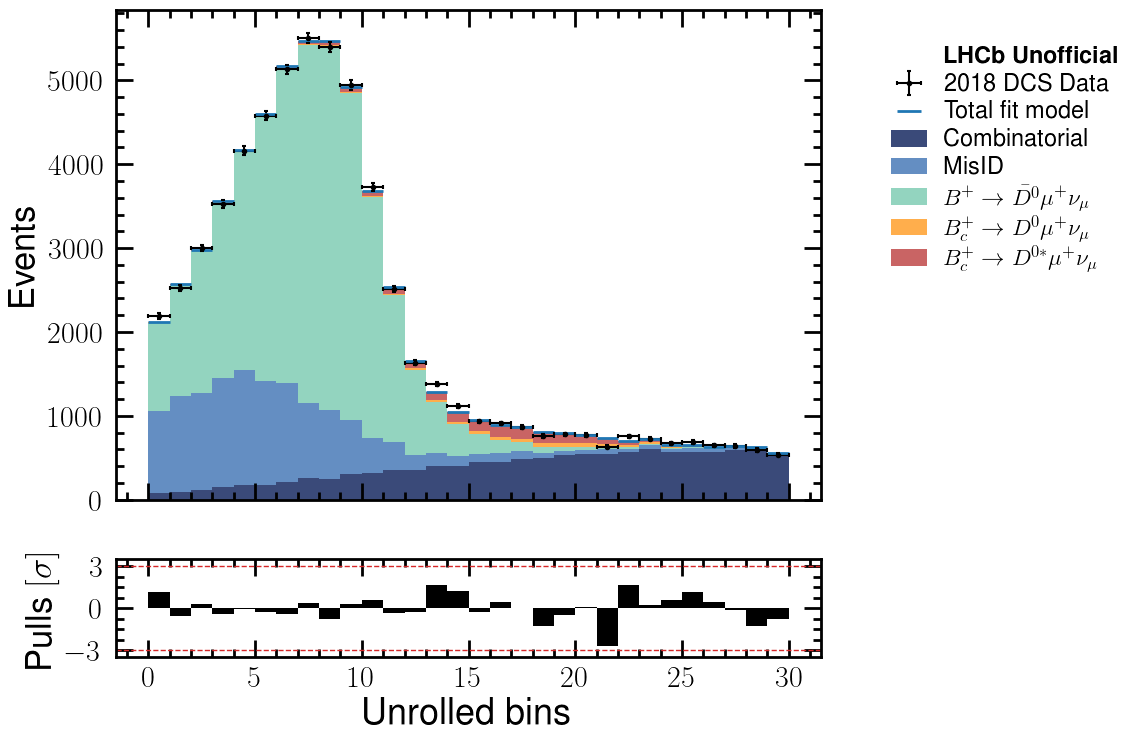

In [73]:
DCS = load_bh("DCS")
    
"""generate 1D projections of the fit and data
pars:
    - bh_projection_axis = which axes to project form nD bh
    - plot_tot_fit_model = if plot tot fit model overlayed on the fit components
""" # sloppy to do it this way, but that's okay sometimes

# load in the DCS observed data and compile all scalings, vars and errors of interest
obs_mcorr_s_i = (DCS.view().variance / DCS.view().value).flatten("F")
obs_mcorr_vals = DCS.view().value.flatten("F") / obs_mcorr_s_i
obs_mcorr_errs = (DCS.view().variance**.5).flatten("F")/ obs_mcorr_s_i
obs_mcorr_bin_centers = np.arange(1, MCORR_NBINS * LTIME_NBINS+1, 1)-0.5
obs_mcorr_bin_widths =  1

# obs_mcorr_s_i=1.

# compile the overall model
proj_fit = pdf.expected_data(bestfit_pars, include_auxdata=False)*obs_mcorr_s_i

# book plot
fig, ax = plt.subplots(2,1,figsize=(12,8),sharex=True,gridspec_kw={'height_ratios': [5, 1]})

# plot the data first
ax0 = ax[0]

ax0.plot([], [], "", label=r"\textbf{LHCb Unofficial}", color="white")

ax0.errorbar(x=obs_mcorr_bin_centers, y=obs_mcorr_vals*obs_mcorr_s_i, yerr=obs_mcorr_errs, xerr=obs_mcorr_bin_widths/2, 
fmt=".", 
color="black", 
label="2018 DCS Data", 
markersize=5,
elinewidth=1.5,
capsize=1.5,
markeredgewidth=1.5,
)

# plot total fit mode
ax0.errorbar(
    x=obs_mcorr_bin_centers, 
    y=proj_fit, 
    xerr=obs_mcorr_bin_widths/2, 
    fmt=".", 
    color="tab:blue", 
    label="Total fit model", 
    elinewidth=2, 
    markersize=.1,
    capsize=.1,
    markeredgewidth=.1,
)

ax0.set_ylabel(rf"Events", fontsize=25, loc="center")

# combinatorial bkg
mcorr_comb_bkg = muprime_vals["COMB"] * PRESCALED_FIT_RESULTS["comb_y"].n * bb * obs_mcorr_s_i
ax0.bar(x=obs_mcorr_bin_centers, height=mcorr_comb_bkg, bottom=[0], width=obs_mcorr_bin_widths, alpha=.8, label=r"Combinatorial",color="#081d58")

# misid background
mcorr_misid_bkg = misid_template.expected_data( [ PRESCALED_FIT_RESULTS["misid_y_constr"].n], include_auxdata=False )*bb * obs_mcorr_s_i
ax0.bar(x=obs_mcorr_bin_centers, height=mcorr_misid_bkg, bottom=mcorr_comb_bkg, width=obs_mcorr_bin_widths, alpha=.7, label=r"MisID", color="#225ea8")

# # B+ background
mcorr_bu_bkg = bu_template.expected_data( [ PRESCALED_FIT_RESULTS["bu_y_constr"].n], include_auxdata=False )*bb * obs_mcorr_s_i
ax0.bar(x=obs_mcorr_bin_centers, height=mcorr_bu_bkg, bottom=mcorr_comb_bkg+mcorr_misid_bkg, width=obs_mcorr_bin_widths, alpha=.7, label=r"$B^{+}\rightarrow \bar{D^0} \mu^+ \nu_\mu$", color="#66c2a5")

# D0Mu signal
mcorr_D0_sig = D0_template.expected_data( [ PRESCALED_FIT_RESULTS["dz_intgr"].n, PRESCALED_FIT_RESULTS["dst_sig_y"].n, PRESCALED_FIT_RESULTS["kappa"].n ], include_auxdata=False )*bb * obs_mcorr_s_i
mcorr_D0_err = D0_template.expected_data( [ PRESCALED_FIT_RESULTS["dz_intgr"].n, PRESCALED_FIT_RESULTS["dst_sig_y"].s, PRESCALED_FIT_RESULTS["kappa"].s ], include_auxdata=False )*bb * obs_mcorr_s_i
ax0.bar(x=obs_mcorr_bin_centers, height=mcorr_D0_sig, bottom=mcorr_comb_bkg+mcorr_misid_bkg + mcorr_bu_bkg, width=obs_mcorr_bin_widths, alpha=.7, label=r"$B_c^+ \rightarrow D^{0}\mu^+\nu_\mu$", color="darkorange")

# Dst signal
mcorr_Dst_sig = Dst_template.expected_data( [ PRESCALED_FIT_RESULTS["dst_intgr"].n, PRESCALED_FIT_RESULTS["dst_sig_y"].n ], include_auxdata=False )*bb*obs_mcorr_s_i
mcorr_Dst_err = Dst_template.expected_data( [ PRESCALED_FIT_RESULTS["dst_intgr"].n, PRESCALED_FIT_RESULTS["dst_sig_y"].s ], include_auxdata=False )*bb*obs_mcorr_s_i
ax0.bar(x=obs_mcorr_bin_centers, height=mcorr_Dst_sig, bottom=mcorr_comb_bkg+mcorr_misid_bkg + mcorr_bu_bkg + mcorr_D0_sig, width=obs_mcorr_bin_widths, alpha=.7, label=r"$B_c^+ \rightarrow D^{0*}\mu^+\nu_\mu$", color="firebrick")

#ax0.set_yscale("log")
ax0.legend(fontsize=17, bbox_to_anchor=(1.05, 1), loc='upper left')

#pull plot (missing errors on pulls)
ax1 = ax[1]
ax[1].set_ylim(bottom=-3.5, top=3.5)
ax[1].axhline(y=-3, color="tab:red", lw=1, ls="--")
ax[1].axhline(y=3, color="tab:red", lw=1, ls="--")
ax[1].set_yticks([-3, 0,  3], minor=False)
PULLS = (obs_mcorr_vals*obs_mcorr_s_i - proj_fit) / (obs_mcorr_errs * obs_mcorr_s_i)

ax1.bar(x=obs_mcorr_bin_centers, height=PULLS, width=obs_mcorr_bin_widths, alpha=1.,  color="black")

# #plt.ylabel(r"$\frac{obs-fit}{\sigma_{obs}}$")
ax1.set_ylabel(rf"Pulls $[\sigma]$", loc="center", fontsize=25)

fig.tight_layout()
plt.xlabel(r"Unrolled bins", loc="center")

In [62]:
# print fit results, removing the s_i precaling
dst_yield = np.sum(mcorr_Dst_sig) 
dst_yield_err = np.sum(mcorr_Dst_err) 
dz_yield = np.sum(mcorr_D0_sig) 
dz_yield_err = np.sum(mcorr_D0_err) 

headers= [
    "Signal channel", "Fit resuts (*B&Z events*)"
]

table = [
    [f"Bc->D0MuNu", f"{dz_yield:.0f} +/- {dz_yield_err:.0f}"],
    [f"Bc->D*MuNu", f"{dst_yield:.0f} +/- {dst_yield_err:.0f}"],
]
print(tabulate(table, headers, tablefmt="fancy_grid"))
print(c("to-do: ensure error propagation is performed correctly").magenta)


╒══════════════════╤═════════════════════════════╕
│ Signal channel   │ Fit resuts (*B&Z events*)   │
╞══════════════════╪═════════════════════════════╡
│ Bc->D0MuNu       │ 497 +/- 233                 │
├──────────────────┼─────────────────────────────┤
│ Bc->D*MuNu       │ 1878 +/- 310                │
╘══════════════════╧═════════════════════════════╛
to-do: ensure error propagation is performed correctly


In [49]:
# print fit results, removing the s_i precaling
dst_yield = np.sum(mcorr_Dst_sig) 
dst_yield_err = np.sum(mcorr_Dst_err) 
dz_yield = np.sum(mcorr_D0_sig) 
dz_yield_err = np.sum(mcorr_D0_err) 

headers= [
    "Signal channel", "Fit resuts (*B&Z events*)"
]

table = [
    [f"Bc->D0MuNu", f"{dz_yield:.0f} +/- {dz_yield_err:.0f}"],
    [f"Bc->D*MuNu", f"{dst_yield:.0f} +/- {dst_yield_err:.0f}"],
]
print(tabulate(table, headers, tablefmt="fancy_grid"))
print(c("to-do: ensure error propagation is performed correctly").magenta)


╒══════════════════╤═════════════════════════════╕
│ Signal channel   │ Fit resuts (*B&Z events*)   │
╞══════════════════╪═════════════════════════════╡
│ Bc->D0MuNu       │ 474 +/- 216                 │
├──────────────────┼─────────────────────────────┤
│ Bc->D*MuNu       │ 1419 +/- 292                │
╘══════════════════╧═════════════════════════════╛
to-do: ensure error propagation is performed correctly


In [74]:
# print fit results, removing the s_i precaling
dst_yield = np.sum(mcorr_Dst_sig) 
dst_yield_err = np.sum(mcorr_Dst_err) 
dz_yield = np.sum(mcorr_D0_sig) 
dz_yield_err = np.sum(mcorr_D0_err) 

headers= [
    "Signal channel", "Fit resuts (*B&Z events*)"
]

table = [
    [f"Bc->D0MuNu", f"{dz_yield:.0f} +/- {dz_yield_err:.0f}"],
    [f"Bc->D*MuNu", f"{dst_yield:.0f} +/- {dst_yield_err:.0f}"],
]
print(tabulate(table, headers, tablefmt="fancy_grid"))
print(c("to-do: ensure error propagation is performed correctly").magenta)


╒══════════════════╤═════════════════════════════╕
│ Signal channel   │ Fit resuts (*B&Z events*)   │
╞══════════════════╪═════════════════════════════╡
│ Bc->D0MuNu       │ 504 +/- 242                 │
├──────────────────┼─────────────────────────────┤
│ Bc->D*MuNu       │ 1676 +/- 329                │
╘══════════════════╧═════════════════════════════╛
to-do: ensure error propagation is performed correctly


In [82]:
dzy_16 = ufloat(474, 216)
dzy_17 = ufloat(497, 233)
dzy_18 = ufloat(504, 242)

In [83]:
dzy_16 + dzy_17 + dzy_18

1475.0+/-399.3857784148054

In [84]:
dzy_16 = ufloat(1419, 292)
dzy_17 = ufloat(1878, 310)
dzy_18 = ufloat(1676, 329)

In [85]:
dzy_16 + dzy_17 + dzy_18

4973.0+/-538.1496074513109